# Dynamic mode decomposition with control for 2D spatio-temporal dataset

First of all we import the `DMDc` class from the pydmd package, we set matplotlib for the notebook and we import numpy and scipy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from pydmd import DMD, DMDc
from pydmd.plotter import plot_eigs

Now, we create our dataset: since we want to add the control, the evolution of the complex system can be formally summarized as:
$$
\mathbf{x}_{k+1} = \mathbf{A}\mathbf{x}_k + \mathbf{B}\mathbf{u}_k,
$$where the operators $\mathbf{A}$ and $\mathbf{B}$ are the ones we will approximate using DMD. So, for a demostrative purpose, we create the original snapshots by using two random operators.

In [2]:
def f2(x):
    return 0*x # all zeros

def f1(x, t, amplitude, coeff_x, coeff_t):
    delay_x = coeff_x*t
    delay_t = coeff_t*x
    return amplitude*(np.sin(0.7*(x+delay_x))*(np.cos(0.2*(t+delay_t)) - np.sin(0.1*(t+delay_t))))

n = 50      #Total number of spatial points
k = 300     #Total number of temporal points

X = 10      #Max value of spatial points
T = 300     #Max value of temporal points

m = 150     #Number of training points in time

#Define A and B matrices
A = scipy.linalg.helmert(n, True)
#HELMERT matrix
#  Formula:
#    If I = 1 then
#      A(I,J) = 1 / sqrt ( N )
#    else if J < I then
#      A(I,J) = 1 / sqrt ( I * ( I - 1 ) )
#    else if J = I then
#      A(I,J) = (1-I) / sqrt ( I * ( I - 1 ) )
#    else
#      A(I,J) = 0
B = np.ones((n,n))
B[:] = 1

#Define spatial and temporal points
x = np.linspace(1, X, n)
t = np.linspace(1, T, k)
Tm, Xm = np.meshgrid(t, x)


#Temporal points for training of DMD and MDc algorithms
t_train = t[:m]


#Computer control input data
u = f1(Xm, Tm, 1, 0.1, -0.3)
u_train = u[:,:m-1]


# Compute training data set (snapshots)
snapshot_0 = f2(x)
snapshots = [snapshot_0]

for i in range(m - 1):
    snapshots.append(A.dot(snapshots[i]) + B.dot(u_train[:, i]))

snapshots = np.array(snapshots).T


#Compute the full dataset
Full_function = [snapshot_0]

for i in range(k-1):
    Full_function.append(A.dot(Full_function[i]) + B.dot(u[:, i]))

Full_function = np.array(Full_function).T


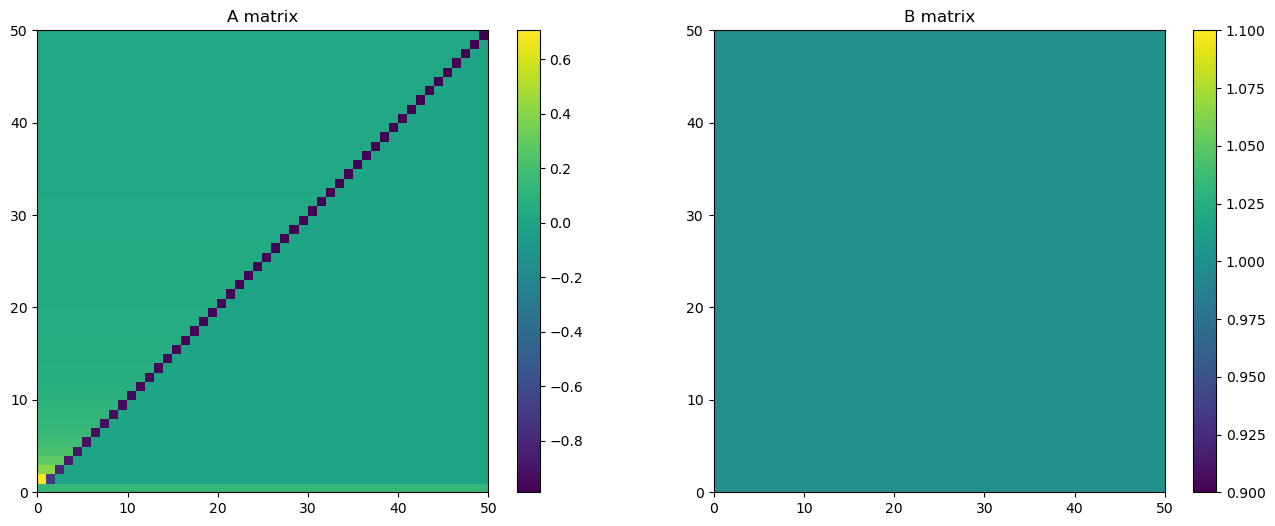

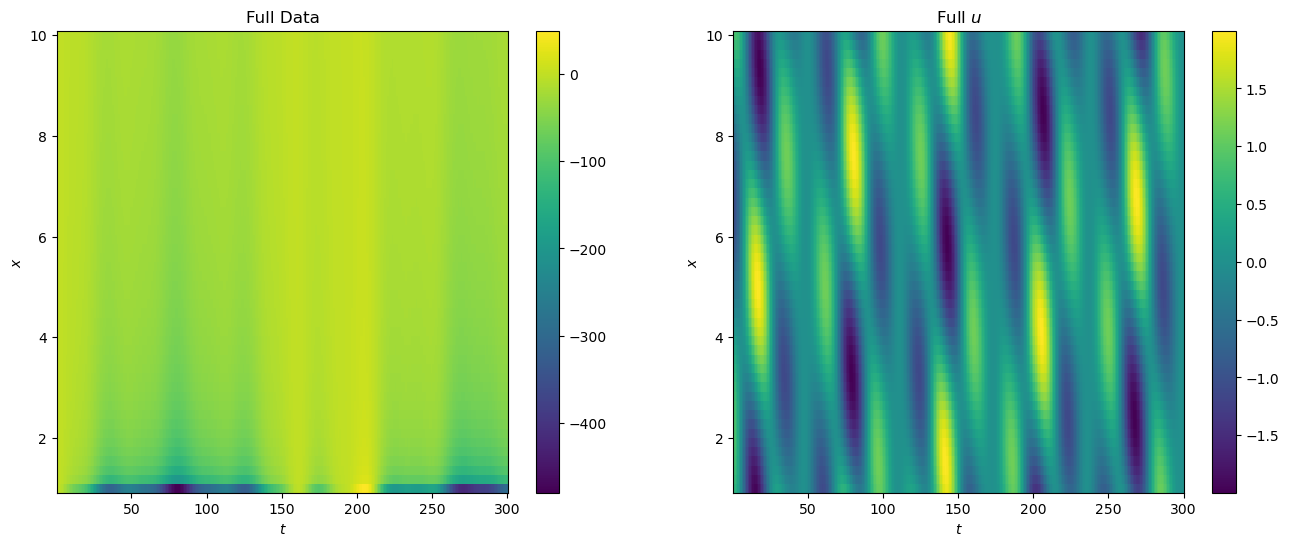

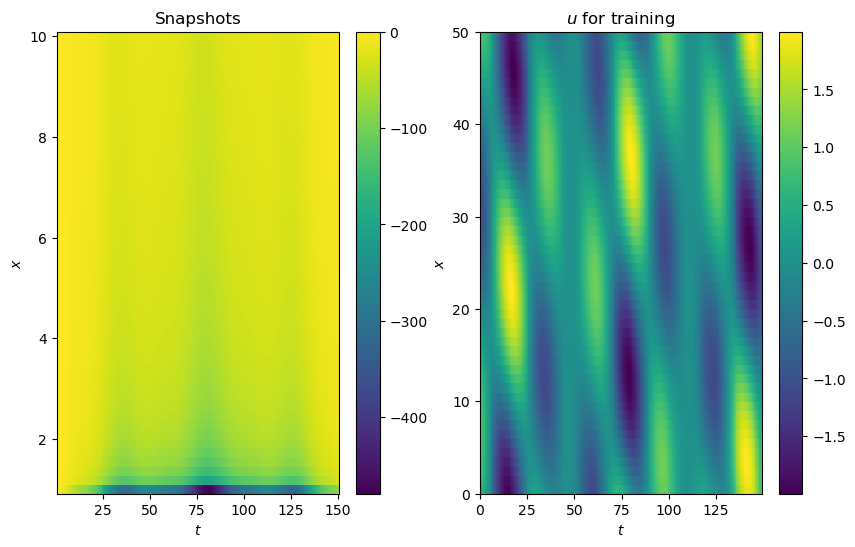

In [3]:
#Plot A and B matrices, snapshots and full data

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title("A matrix")
plt.pcolor(A.real)
plt.colorbar()
plt.subplot(122)
plt.title("B matrix")
plt.pcolor(B.real)
plt.colorbar()
plt.show()

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title("Full Data")
plt.pcolor(t, x, Full_function.real)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.subplot(122)
plt.title("Full $u$")
plt.pcolor(t, x, u.real)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.title("Snapshots")
plt.pcolor(t_train, x, snapshots.real)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.subplot(122)
plt.title("$u$ for training")
plt.pcolor(u_train.real)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

In [4]:
#Compute DMDc using the corresponding classes in PyDMD package

dmdc = DMDc(svd_rank=-1)
dmdc.fit(snapshots, u_train)

/home/phuc/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 2.7600915254895782e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


/home/phuc/.local/lib/python3.10/site-packages/pydmd/plotter.py:195: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x75fc10d1da50>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


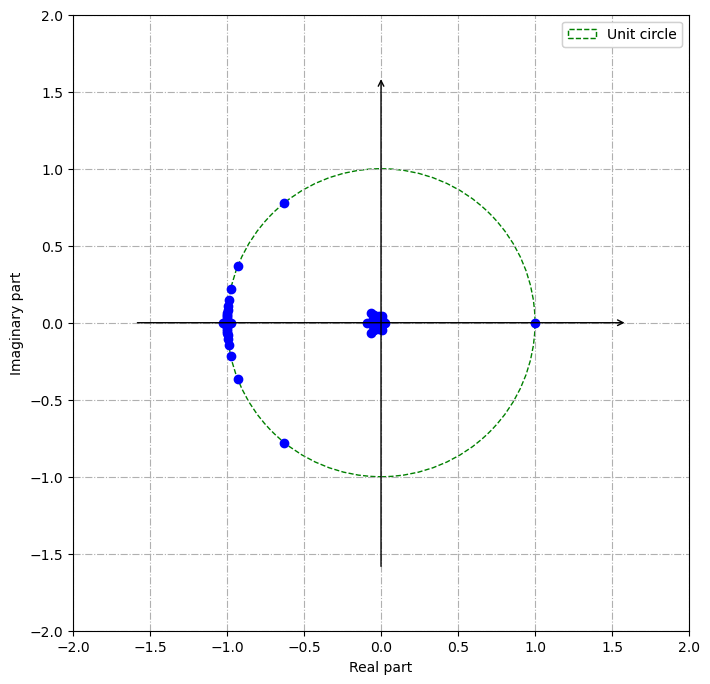

In [5]:
plot_eigs(dmdc)

Well, we built the approximation for $\mathbf{A}$ and for $\mathbf{B}$; we can now test the system with a different control input: differently by the other versions, we can pass as argument of the `reconstructed_data` method the control input we want to test.

Finally, we can also use a different timestep for the reconstruction, obviously passing the proper control input (the number of inputs we pass has to be the number of reconstructed snapshots we try to compute, except for the first snapshots). We continue halving the timestep and create a new random input.

In [6]:
#Define timesteps for DMD and DMDc reconstruction 


dmdc.dmd_time["dt"] = t[1] - t[0]
dmdc.dmd_time["t0"] = t[0]
dmdc.dmd_time["tend"] = t[-1]

/tmp/ipykernel_212044/2567155618.py:15: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()


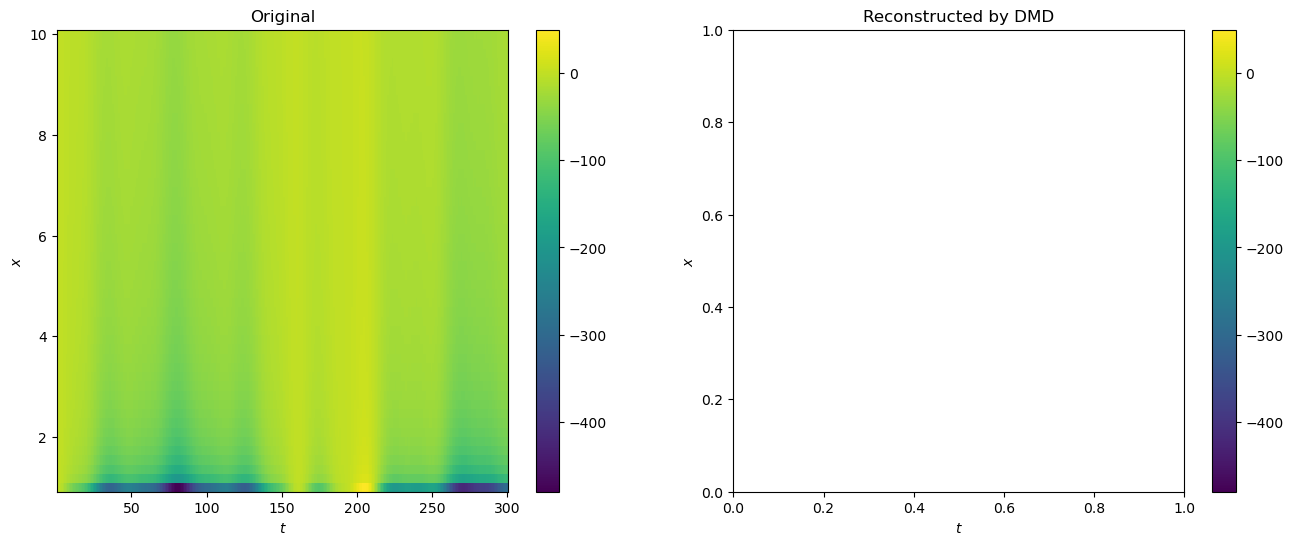

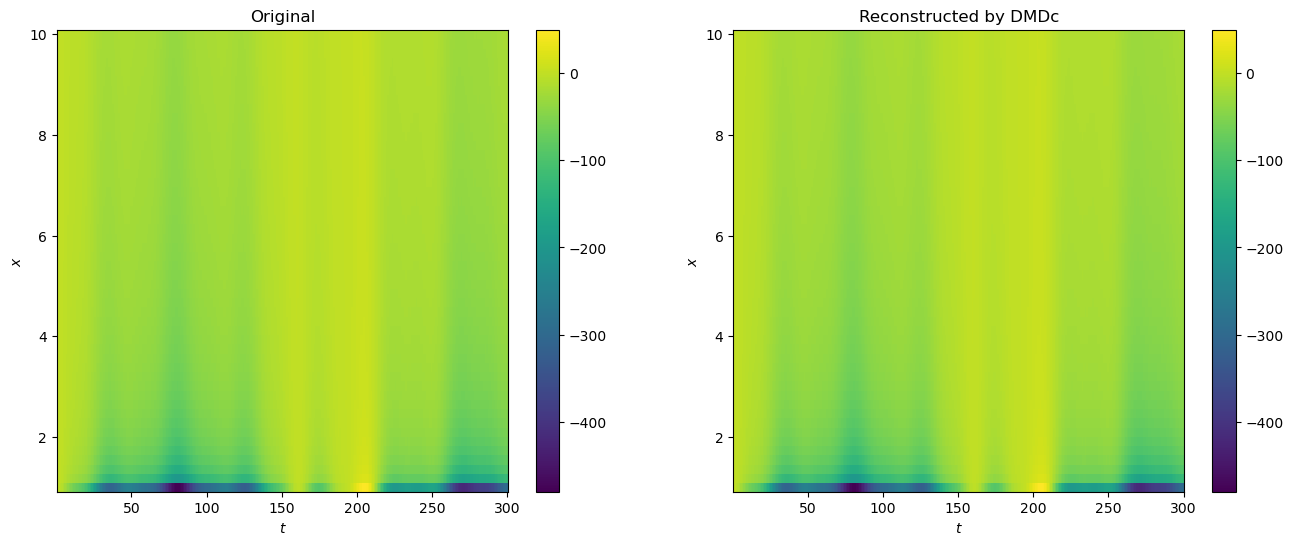

In [7]:
#Plot the original data and reconstructed data by DMD and DMDc methods

plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.title("Original")
plt.pcolor(t, x, Full_function)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.subplot(122)
plt.title("Reconstructed by DMD")
# plt.pcolor(t, x, dmd.reconstructed_data.real)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.title("Original")
plt.pcolor(t, x, Full_function)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.subplot(122)
plt.title("Reconstructed by DMDc")
plt.pcolor(t, x, dmdc.reconstructed_data(u[:,:k-1]).real)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.show()

In [8]:
print("the shape of input u is",u.shape)

the shape of input u is (50, 300)


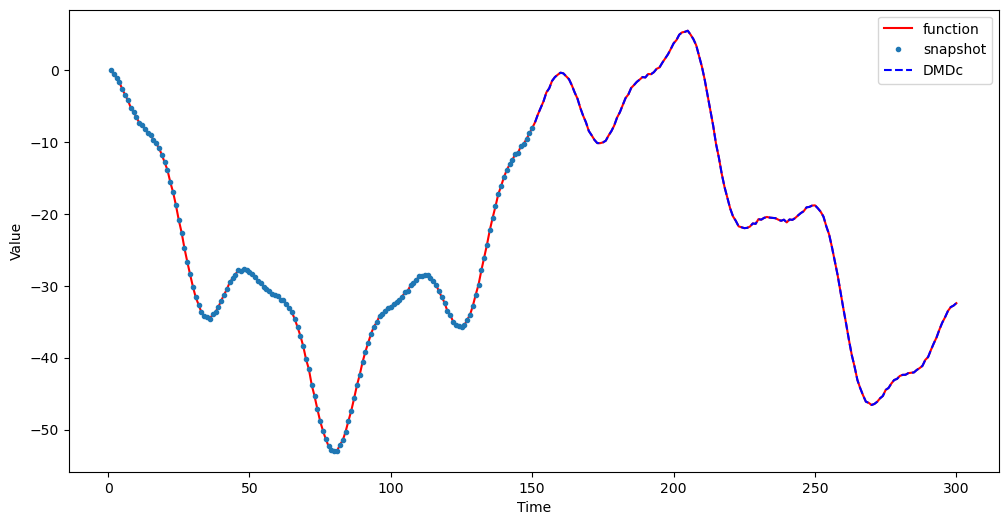

In [9]:
#Plot the original data and reconstructed by DMD/DMDc as a function of time

x_location = 20

plt.figure(figsize=(12,6))
plt.plot(t, Full_function[x_location,:],'-', color = 'r', label='function')
#plt.plot(t, u[x_location,:],'-',label='control')
plt.plot(t_train, snapshots[x_location,:],'.',label='snapshot')
# plt.plot(dmd.dmd_timesteps, dmd.reconstructed_data[x_location,:].real,'--',label ='DMD')
plt.plot(dmdc.dmd_timesteps[m:], dmdc.reconstructed_data(u[:,:k-1])[x_location,m:].real,'--',color='b',label ='DMDc')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [23]:
from improve_dmdc import Improved_DMDc_new, Standard_DMDC
# dmdc.fit(snapshots, u_train)
X_data_all = Full_function
u_con = u

# split the data into training and testing sets
N_t = X_data_all.shape[1]  # Total number of time steps
N_train = int(0.8 * N_t)  # 80% for training
U_control = u_con[:, :N_train-1]  # Control inputs for training
X_data_train = X_data_all[:, :N_train]  # Training data
X_data_test = X_data_all[:, N_train:]  # Testing data

# Apply Improved DMDc
rank_p, rank_r = 100, 50
# timing the algorithms
import time
start_time = time.time()
eigenvalues, modes, recons, bar_A, bar_B, bar_V, time_improved = Improved_DMDc_new(X_data_train, U_control, rank_p, rank_r)
elapsed_time = time.time() - start_time
print(f"Improved DMDc took {elapsed_time:.2f} seconds")
# Apply Standard DMDc
# timing the algorithms
start_time_std = time.time()
eigenvalues_std, modes_std, recons_std, bar_A_std, bar_B_std, bar_V_std, time_standard = Standard_DMDC(X_data_train, U_control, rank_p, rank_r)
elapsed_time_std = time.time() - start_time_std
print(f"Standard DMDc took {elapsed_time_std:.2f} seconds")
nx = 50
# Predict future states
z_k = bar_V.T @ X_data_test  # Reduced initial states
future_steps = N_t - N_train
Y_pred = np.zeros((nx, future_steps))

z_current = z_k[:,0].reshape(-1, 1)  # Initial reduced state

for i in range(future_steps):
    u_current = u_con[:, N_train + i].reshape(1, -1)
    z_next = bar_A @ z_current + bar_B @ u_current.T
    Y_pred[:, i] = (bar_V @ z_next).reshape(nx,)
    z_current = z_next

# Predict future states for standard DMDc
z_k_std = bar_V_std.T @ X_data_test
future_steps = N_t - N_train
Y_pred_std = np.zeros((nx, future_steps))
z_current_std = z_k_std[:,0].reshape(-1, 1)

for i in range(future_steps):
    u_current = u_con[:, N_train+i].reshape(1, -1)
    z_next_std = bar_A_std @ z_current_std + bar_B_std @ u_current.T
    Y_pred_std[:, i] = (bar_V_std @ z_next_std).reshape(nx)
    z_current_std = z_next_std

the shape of X_data is:  (50, 240)
the shape of U_control.shape[1] + 1 is:  240
Improved DMDc took 0.30 seconds
Standard DMDc took 0.33 seconds
